## Observations:
zip is available in address - index on split is -1, -5:

potential interests:
- zip code (reduced to large(-ish?) sample sizes)
- maybe look at geographical location specifically? (Is proximity to city center and features calculable?| $\checkmark$)
  - look into part 2 ^
  - waterfront is listed as a binary column
- (person pref, focus on home buyers/individuals)
- someone mentioned school data - this isn't a bad idea.
  - can get school rankings and their zip codes

would like to get external/additional information. Will check Kaggle for related data sets

https://kingcounty.gov/ <= city website

find out if prices are based on closes or valuations - if closes, can 

### Data cleaning
- multiple y/n / cat. columns that can be converted to dummies for OLS discovery
- view quality can be rated as good/bad/avg. , could be extrapolated to 0-2 (more if more options there)
- grade?

<hr/>
Data from [column_names.md](data/column_names.md)  
vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv

* `view` - Quality of view from house
  * Includes views of Mt. Rainier, Olympics, Cascades, Territorial, Seattle Skyline, Puget Sound, Lake Washington, Lake Sammamish, small lake / river / creek, and other
* `condition` - How good the overall condition of the house is. Related to maintenance of house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each condition code
* `grade` - Overall grade of the house. Related to the construction and design of the house.
  * See the [King County Assessor Website](https://info.kingcounty.gov/assessor/esales/Glossary.aspx?type=r) for further explanation of each building grade code
<hr/>

lots of relevant info for discovery in there

# _*IMPORTANT*_

Most fields were pulled from the [King County Assessor Data Download](https://info.kingcounty.gov/assessor/DataDownload/default.aspx).

The `address`, `lat`, and `long` fields have been retrieved using a third-party [geocoding API](https://docs.mapbox.com/api/search/geocoding/). In some cases due to missing or incorrectly-entered data from the King County Assessor, this API returned locations outside of King County, WA. If you plan to use the `address`, `lat`, or `long` fields in your modeling, consider identifying outliers prior to including the values in your model

<br/><hr/><br/><hr/>

excluding < 400sqft, tiny home by definition per:
"A dwelling unit that is 400 square feet (37 m2) or less in floor area excluding sleeping lofts"
src: https://www.seattle.gov/documents/Departments/SDCI/Codes/SeattleResidentialCode/2018SRCAppendixQ.pdf

### imports

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import statsmodels.api as sm
import numpy as np

from code.features import has_feature

In [36]:
housing_df = pd.read_csv('data/kc_house_data.csv')
zip_codes = pd.read_csv('data/King_County_Zip_Codes.csv')

## Base Variable Definitions

define seaborn theme as on

In [37]:
sns.set()

In [38]:
alpha = 0.05            # default confidence 
upper_cost = 5000000    # <= $5,000,000 

## ALL DF Definitions
merge these more cleanly in the index

bring in zip codes from _*ONLY*_ King County (data from: https://www.zip-codes.com/county/wa-king.asp) and take out any data outside of the county

In [39]:
housing_df['zip'] = housing_df['address'].map(lambda x: x.split(',')[-2][-5:])
housing_df['town']= housing_df['address'].map(lambda x: x.split(',')[-3].strip())
housing_df.drop(columns=['address','lat','long'])
kc_only = housing_df.merge(zip_codes['Zip Codes'].astype(str),left_on='zip',right_on='Zip Codes',how='inner')

In [40]:
display(kc_only.info(), kc_only.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29189 entries, 0 to 29188
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             29189 non-null  int64  
 1   date           29189 non-null  object 
 2   price          29189 non-null  float64
 3   bedrooms       29189 non-null  int64  
 4   bathrooms      29189 non-null  float64
 5   sqft_living    29189 non-null  int64  
 6   sqft_lot       29189 non-null  int64  
 7   floors         29189 non-null  float64
 8   waterfront     29189 non-null  object 
 9   greenbelt      29189 non-null  object 
 10  nuisance       29189 non-null  object 
 11  view           29189 non-null  object 
 12  condition      29189 non-null  object 
 13  grade          29189 non-null  object 
 14  heat_source    29160 non-null  object 
 15  sewer_system   29176 non-null  object 
 16  sqft_above     29189 non-null  int64  
 17  sqft_basement  29189 non-null  int64  
 18  sqft_g

None

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,lat,long
count,2.918900e+04,2.918900e+04,29189.000000,29189.000000,29189.000000,2.918900e+04,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000,29189.000000
mean,4.535750e+09,1.113059e+06,3.435335,2.331889,2130.911987,1.720745e+04,1.516564,1825.949844,480.890747,336.257666,216.342972,1973.827401,93.931344,47.543297,-122.214229
std,2.882323e+09,8.957550e+05,0.978759,0.896124,977.502626,6.131060e+04,0.548233,880.928042,586.056457,286.283099,246.810496,31.681435,422.974700,0.145975,0.143445
min,1.000055e+06,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,47.155265,-122.526650
25%,2.085201e+09,6.450000e+05,3.000000,2.000000,1440.000000,5.000000e+03,1.000000,1190.000000,0.000000,0.000000,40.000000,1952.000000,0.000000,47.430940,-122.328435
50%,3.874000e+09,8.685000e+05,3.000000,2.500000,1940.000000,7.560000e+03,1.500000,1580.000000,0.000000,400.000000,140.000000,1976.000000,0.000000,47.557810,-122.233905
75%,7.287100e+09,1.310000e+06,4.000000,3.000000,2640.000000,1.078400e+04,2.000000,2290.000000,960.000000,510.000000,310.000000,2001.000000,0.000000,47.672005,-122.127477
max,9.904000e+09,3.075000e+07,13.000000,10.500000,15360.000000,3.253932e+06,4.000000,12660.000000,8020.000000,3580.000000,4370.000000,2022.000000,2022.000000,47.789830,-121.163960


reduce df down to only houses that are not legally considered tiny homes, have bedrooms, and have at least a half-bath  
also, remove the lat and long columns - they are not being used  
<sub>come back to this later to clean data for visibility if necessary</sub>

output to homes_df variable

convert features from sqft to binary have/have-not column  
because this is in 1 and 0, this doesn't need to be dummied and dropped

In [42]:
new_columns   = ['has_basement' ,'has_garage' ,'has_patio' ,'is_renovated']
check_columns = ['sqft_basement','sqft_garage','sqft_patio','yr_renovated']
kc_only[new_columns] = kc_only[check_columns].apply(has_feature)
kc_only.drop(columns=check_columns,inplace=True)
kc_only.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,address,lat,long,zip,town,Zip Codes,has_basement,has_garage,has_patio,is_renovated
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055,Renton,98055,0,0,1,0
1,3340401570,3/2/2022,750000.0,3,2.0,1830,7969,1.0,NO,NO,...,"306 South 15th Street, Renton, Washington 9805...",47.466730,-122.21400,98055,Renton,98055,1,1,1,1
2,7399301200,3/29/2022,728000.0,4,2.0,2170,7520,1.0,NO,NO,...,"1814 Aberdeen Avenue Southeast, Renton, Washin...",47.463930,-122.18974,98055,Renton,98055,1,1,1,0
3,9899200050,3/24/2022,565000.0,4,2.0,1400,10364,1.5,NO,NO,...,"3426 Shattuck Avenue South, Renton, Washington...",47.448450,-122.21243,98055,Renton,98055,0,1,1,0
4,6673070070,12/28/2021,645000.0,3,2.0,1520,8250,1.0,NO,NO,...,"2209 Southeast 21st Street, Renton, Washington...",47.460870,-122.18869,98055,Renton,98055,1,1,1,0


create homes_df from kc_only ; include only sqft > 400 (tiny home max. sqft), has bedroom, has bath, price < upper_cost (default $5,000,000)  
drop unnecessary columns

In [8]:
homes_df = kc_only[(kc_only['sqft_living'] > 400) &
    (kc_only['bedrooms'] > 0) &
    (kc_only['bathrooms'] > 0) &
    (kc_only['price'] < upper_cost)                        # <= dropping houses valued at and over $5,000,000 - most demographics will not be looking for this.
    ]

In [11]:
# get zip codes that have at least 100 entries

zip_counts = homes_df['zip'].value_counts().rename('zip_counts')
zips_counted = homes_df.merge(
    zip_counts,
    left_on='zip',
    right_index=True
)
zips_counted.info()
min_zips = zips_counted[zips_counted['zip_counts'] >= 100]
min_zips

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28919 entries, 0 to 29188
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             28919 non-null  int64  
 1   date           28919 non-null  object 
 2   price          28919 non-null  float64
 3   bedrooms       28919 non-null  int64  
 4   bathrooms      28919 non-null  float64
 5   sqft_living    28919 non-null  int64  
 6   sqft_lot       28919 non-null  int64  
 7   floors         28919 non-null  float64
 8   waterfront     28919 non-null  object 
 9   greenbelt      28919 non-null  object 
 10  nuisance       28919 non-null  object 
 11  view           28919 non-null  object 
 12  condition      28919 non-null  object 
 13  grade          28919 non-null  object 
 14  heat_source    28899 non-null  object 
 15  sewer_system   28908 non-null  object 
 16  sqft_above     28919 non-null  int64  
 17  sqft_basement  28919 non-null  int64  
 18  sqft_g

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,yr_built,yr_renovated,address,zip,town,Zip Codes,has_basement,has_garage,has_patio,zip_counts
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",98055,Renton,98055,0,0,1,219
1,3340401570,3/2/2022,750000.0,3,2.0,1830,7969,1.0,NO,NO,...,1950,2008,"306 South 15th Street, Renton, Washington 9805...",98055,Renton,98055,1,1,1,219
2,7399301200,3/29/2022,728000.0,4,2.0,2170,7520,1.0,NO,NO,...,1973,0,"1814 Aberdeen Avenue Southeast, Renton, Washin...",98055,Renton,98055,1,1,1,219
3,9899200050,3/24/2022,565000.0,4,2.0,1400,10364,1.5,NO,NO,...,1971,0,"3426 Shattuck Avenue South, Renton, Washington...",98055,Renton,98055,0,1,1,219
4,6673070070,12/28/2021,645000.0,3,2.0,1520,8250,1.0,NO,NO,...,1981,0,"2209 Southeast 21st Street, Renton, Washington...",98055,Renton,98055,1,1,1,219
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29092,723039050,12/16/2021,1826000.0,2,3.0,2070,71264,2.0,NO,NO,...,2001,0,"10717 Southwest Biloxi Road, Vashon, Washingto...",98070,Vashon,98070,1,1,1,193
29093,2022039037,4/14/2022,256000.0,2,1.0,1330,113815,1.0,NO,NO,...,1911,1962,"9632 Southwest Bayview Drive, Vashon, Washingt...",98070,Vashon,98070,0,1,0,193
29094,2322039033,7/14/2021,950000.0,2,2.5,1960,11406,2.0,NO,NO,...,1938,1985,"4510 Southwest 244th Street, Vashon, Washingto...",98070,Vashon,98070,1,1,1,193
29095,3023039221,9/21/2021,450000.0,2,2.0,840,138520,1.0,NO,NO,...,2020,0,"16097 109th Avenue Southwest, Vashon, Washingt...",98070,Vashon,98070,0,0,1,193


In [12]:
zip_by_price_median = min_zips[
    ['zip','price']].groupby(by='zip').agg(
        {'price':'median','zip':'size'}
        ).rename(
            columns={'zip':'count'}
        ).reset_index().sort_values('price',ascending=False)
zip_by_price_median

,zip,price,count
3,98004,2672500.0,258
24,98040,2300000.0,323
4,98005,1956000.0,178
21,98033,1832687.5,600
38,98075,1830500.0,410
...,...,...,...
12,98022,567230.0,454
2,98003,550000.0,439
20,98032,549950.0,183
63,98168,540000.0,383


In [54]:
y = homes_df['price']
X = sm.add_constant(
pd.get_dummies(homes_df['zip']).drop(
    zip_by_price_median.iloc[0]['zip'],     # <= selectl the (median) highest-priced zip to drop it
    axis=1
    ))

logy = True

y = np.log(y) if logy else y

zip_model = sm.OLS(y,X).fit().summary2()
print(zip_model)

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.446     
Dependent Variable: price            AIC:                31726.1058
Date:               2023-03-28 18:06 BIC:                32354.7971
No. Observations:   28919            Log-Likelihood:     -15787.   
Df Model:           75               F-statistic:        310.8     
Df Residuals:       28843            Prob (F-statistic): 0.00      
R-squared:          0.447            Scale:              0.17492   
---------------------------------------------------------------------
            Coef.    Std.Err.      t       P>|t|     [0.025    0.975]
---------------------------------------------------------------------
const      14.7461     0.0260   566.3280   0.0000   14.6950   14.7971
98001      -1.4719     0.0310   -47.5374   0.0000   -1.5326   -1.4112
98002      -1.7263     0.0340   -50.7191   0.0000   -1.7930   -1.6596
98003      -1.5283     0.0328   -46.5817   0.0000   -1

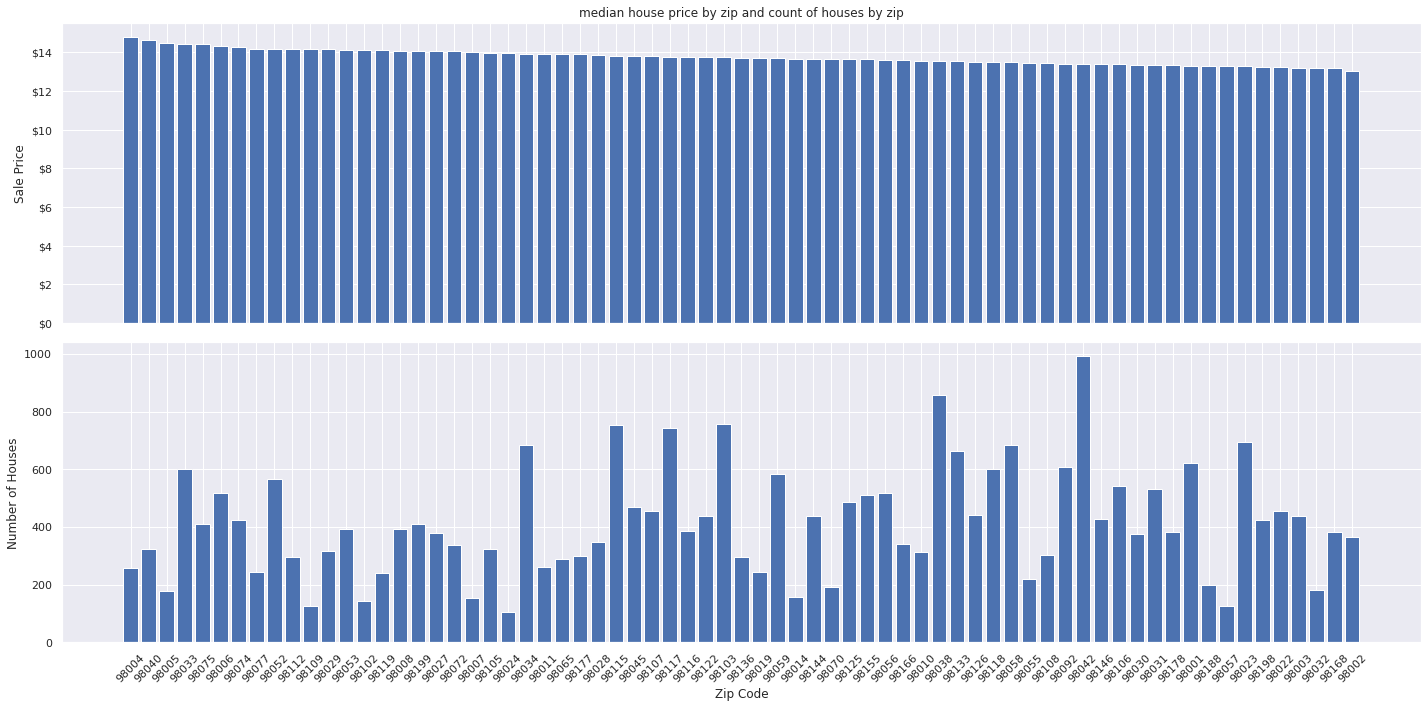

In [55]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(20,10))

y=[zip_by_price_median['price'],zip_by_price_median['count']]
x = zip_by_price_median['zip']
y[0]=np.log(y[0]) if logy else y[0]
ax[0].bar(x=x, height=y[0])
ax[1].bar(x=x, height=y[1])

ax[0].set(
    title='median house price by zip and count of houses by zip',
    ylabel='Sale Price'
)
ax[1].set(
    ylabel='Number of Houses',
    xlabel='Zip Code',
)

dollar_format = mtick.StrMethodFormatter('${x:,.0f}')
ax[0].yaxis.set_major_formatter(dollar_format)
plt.xticks(rotation=45)
plt.tight_layout()
'';


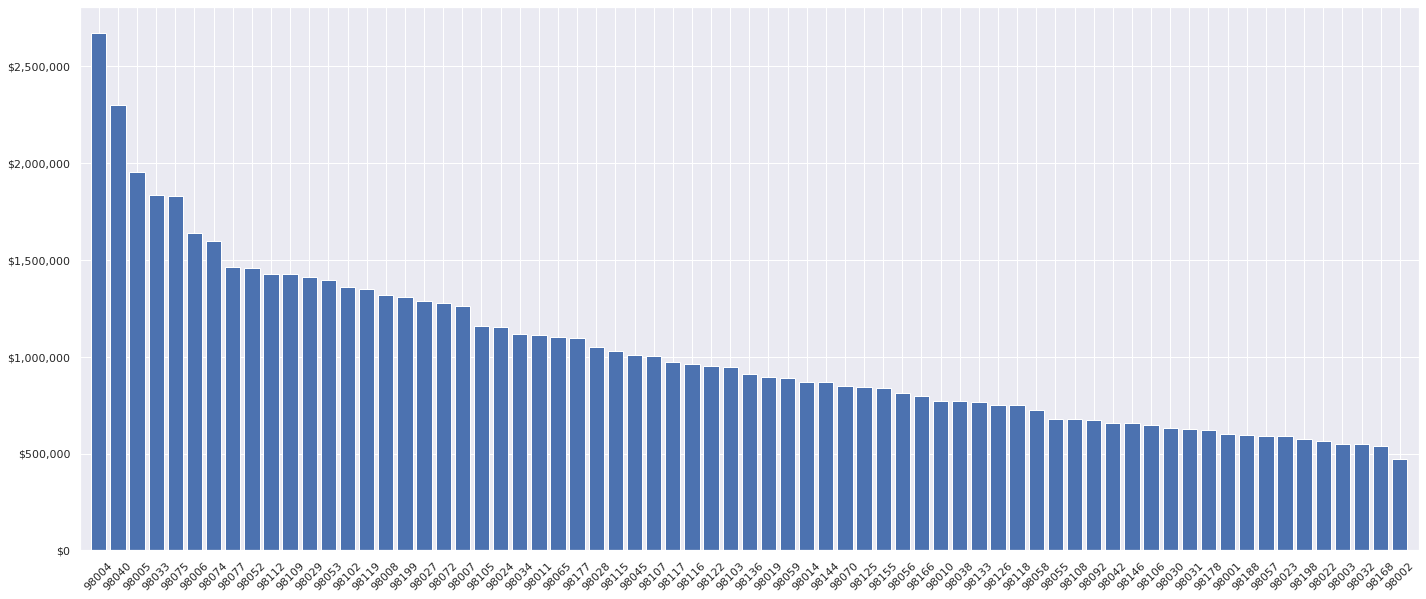

In [15]:
fig, ax = plt.subplots(figsize=(24,10))

dollar_format = mtick.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(dollar_format)

ax.bar(range(0,len(zip_by_price_median['zip'])),zip_by_price_median['price'])
ax.set(
    xlim=(-1,len(zip_by_price_median['zip'])),
    xticks=(np.arange(len(zip_by_price_median['zip']))),
    xticklabels=zip_by_price_median['zip']
)

plt.xticks(rotation=45)

'';

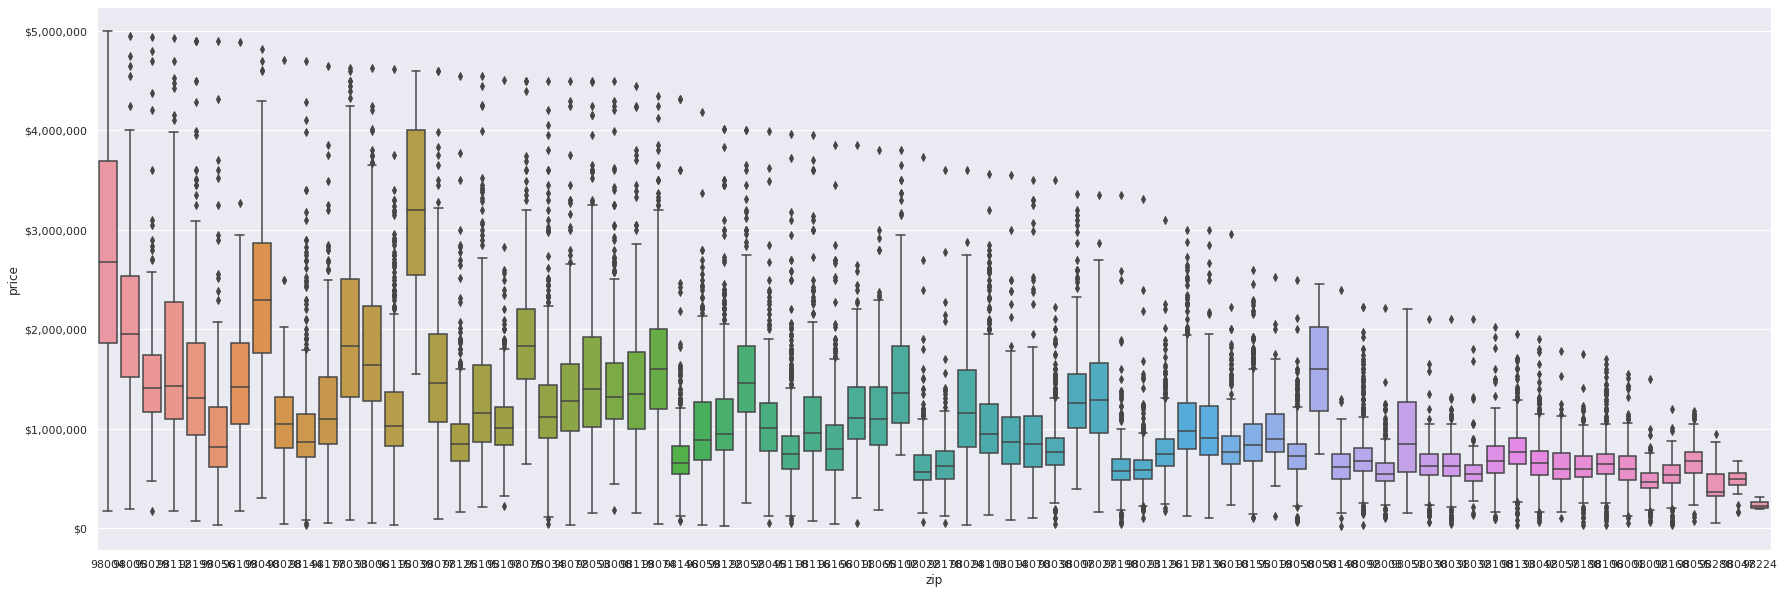

In [16]:
fig, ax = plt.subplots(figsize=(30,10))

data = homes_df[['zip','price']].sort_values('price',ascending=False)

dollar_format = mtick.StrMethodFormatter('${x:,.0f}')
ax.yaxis.set_major_formatter(dollar_format)

sns.boxplot(x='zip',y='price',data=data)
'';

In [20]:
zip_model_df = zip_model.tables[1]

In [21]:
cost_differential_by_zip_lowest_10 = zip_model_df.iloc[1:][
    zip_model_df['P>|t|'] <= alpha
    ].sort_values('Coef.', ascending=True)[
        ['Coef.','Std.Err.']
        ].reset_index().head(
            10
            ).rename(columns={'index':'zip'})

cost_differential_by_zip_lowest_10

<ipython-input-21-658dc098cb78>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cost_differential_by_zip_lowest_10 = zip_model_df.iloc[1:][


,zip,Coef.,Std.Err.
0,98224,-2.541348e+06,247771.924149
1,98288,-2.343053e+06,119880.827471
2,98002,-2.308247e+06,40019.894924
3,98047,-2.290261e+06,63856.996014
4,98168,-2.241869e+06,39606.008038
5,98003,-2.200451e+06,38575.856051
6,98032,-2.200141e+06,47525.335715
7,98001,-2.166156e+06,36406.201994
8,98023,-2.166148e+06,35863.699312
9,98198,-2.161297e+06,38827.613914


In [22]:
cost_differential_by_zip_top_10 = zip_model_df.iloc[1:][
    zip_model_df['P>|t|'] <= alpha
    ].sort_values('Coef.', ascending=False)[
        ['Coef.','Std.Err.']
        ].reset_index().head(
            10
            ).rename(columns={'index':'zip'})

cost_differential_by_zip_top_10

<ipython-input-22-1393efeb17b1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cost_differential_by_zip_top_10 = zip_model_df.iloc[1:][


,zip,Coef.,Std.Err.
0,98039,5.062378e+05,88579.093501
1,98040,-4.109384e+05,41059.934149
2,98005,-6.272128e+05,47914.249165
3,98033,-8.012178e+05,36609.977522
4,98075,-8.875416e+05,39077.587695
5,98006,-9.872939e+05,37483.231330
6,98112,-1.072893e+06,41883.259279
7,98074,-1.099787e+06,38810.329535
8,98077,-1.180623e+06,43912.522862
9,98050,-1.182348e+06,349062.439603


# RUN FROM HERE UP

In [ ]:
homes_df.info()

In [ ]:
sns.PairGrid(homes_df.iloc[:,2:],y_vars='price').map(sns.scatterplot)
'';

In [ ]:
homes_df.columns

In [ ]:
# this is a list of all of the columns in the dataframe
X_vals = [
#    'id',              # mostly useless
#    'date',            # not useful here' may be later
#    'price',           # this is y-val, needs dropped to avoid collinearity
    'bedrooms',
    'bathrooms',
    'sqft_living',
    'sqft_lot',
    'floors',
#    'waterfront',      # dummy
#    'greenbelt',       # dummy
#    'nuisance',        # dummy
#    'view',            # needs dummied
#    'condition',       # would need to be dummied out
#    'grade',           # not in a format we can use yet. May fix this.
#    'heat_source',     # dummy
#    'sewer_system',    # dummy
    'sqft_above',
#    'sqft_basement',   # already have the has_xyz columns, may switch back to these
#    'sqft_garage',     # ^
#    'sqft_patio',      # ^
    'yr_built',
    'yr_renovated',
#    'address',         # not numerical, little data is here - may be useful if we do a mapping function
#    'zip',             # may make this into a cat. column/dummy column later, lots of cats though... (76)
#    'town',            # dummy if needed
#    'Zip Codes',       # <= only need/want 1 zip code column
    'has_basement',
    'has_garage',
    'has_patio'
]
X_vals

In [ ]:
homes_df.value_counts('zip').shape

In [ ]:
homes_df.value_counts('town').shape

In [ ]:
homes_df[X_vals]

In [ ]:
y = homes_df['price']
X = sm.add_constant(homes_df[X_vals])
print(sm.OLS(y,
    X).fit().summary())

### Getting OLS for houses by zip code

In [ ]:
zip_by_price_median.iloc[0]['zip']

adj R<sup>2</sup> >0.38 - worth investigation  
several zips with P>|t| < 0.05, shows significance of those zips vs. base zip (most common)  
high abs(coef) in several cases as well, some high std.er, t stat varies

In [ ]:
zip_by_price_median.sort_values(by='count')

In [ ]:
homes_df[['zip','price']]

In [ ]:
fig, ax = plt.subplots()
ax.boxplot(homes_df[['zip','price']].groupby('zip'))

In [ ]:
pd.set_option('display.max_rows',30)
homes_df[['town','zip','price']].sort_values('price',ascending=False).groupby(by=['town','zip']).agg('median')

## Narrowing zipcode data


In [ ]:
zip_model_df1.columns

<hr/>

<hr/>

## get_zip(s)() block

define zipcode lookup functions, may not be useful or used - keep for reference

In [ ]:
# TODO: ##################################
# move this to code/ if it proves useful #
##########################################

import geopy # <= `conda install -c conda-forge geopy`

def get_zip(
    latitude,
    longitude,
    return_errors=False
    ):
    """_summary_

    Args:
        latitude (float): the latitude of a target address
        longitude (float): the longitude of a target address
        return_errors (bool): whether to return errors or None, useful for "dirty" data. Defaults to False.

    Returns:
        str: string zip/post code of the requested long/lat
    """
    geoloc = geopy.Nominatim(user_agent='check_1')
    try:
        location = geoloc.reverse(f"{latitude},{longitude}")
        return location.raw['address']['postcode']
    except:
        return ValueError() if return_errors else None

def get_zips(
    latitudes,
    longitudes,
    return_errors=False
    ):
    """_summary_

    Args:
        latitude (list): the latitudes of a target address. Should be a list of floats.
        longitude (list): the longitudes of a target address. Should be a list of floats.
        return_errors (bool, optional): whether to return errors or None, useful for "dirty" data. Defaults to False.

    Returns:
        list: list of zip codes (str) based on latitude and longitude provided
    """
    try:
        if len(latitudes) == len(longitudes):
            location = [get_zip(_lat, _long, return_errors) for (_lat,_long) in zip(latitudes,longitudes)]
            return location
    except:
        if return_errors:
            raise ValueError(f'Error(s) raised in thread: {Exception}')
        else:
            return None

In [ ]:
# display(
#     housing_df[['lat','long']],
#     housing_df[['lat','long']].info()
#     )

In [ ]:
# get_zip(47.449490, -122.18908)

In [ ]:
# get_zips(
#     list(housing_df['lat'])[:10],
#     list(housing_df['long'])[:10],
#     True
#     )

In [ ]:
# ofst = 150
# z = ofst + 0
# slc = ofst + 100
# get_zips(
#     list(housing_df['lat'])[z:slc],
#     list(housing_df['long'])[z:slc],
#     return_errors = False
#     )

<hr/>

In [ ]:
housing_df[housing_df['yr_renovated'] >= 1990]['price'].mean()

In [ ]:
housing_df['price'].mean()


In [ ]:
housing_df[housing_df['yr_renovated'] >= 1990]['price'].mean() -housing_df['price'].mean()

In [ ]:
kc_only['heat_source']

In [ ]:
heating_types = homes_df[['heat_source','price']].groupby(by='heat_source').agg('mean','count')
heating_types

In [ ]:
display(homes_df.info(), homes_df.describe())

In [ ]:
kc_only[kc_only['price'] >= 10000000].value_counts('zip')

In [ ]:
kc_only[kc_only['price'] >= 10000000].sort_values('price', ascending=False)